<!-- TODO:
- Add linked histogram to select part of the graph and display the returns profile
- Link all widgets to allow updating of start and end dates and add new tickers
- Refactor into object orientated
- Add correlations heatmap
- Tidy up css
-->

In [1]:
import datetime
import time
import warnings
from typing import Tuple

import calmap
import ffn
import ipywidgets as widgets
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import HTML, display

warnings.filterwarnings("ignore")

In [2]:
%matplotlib inline
%load_ext nb_black

<IPython.core.display.Javascript object>

In [3]:
stock_list = {
    "SNP500": "spy",
    "Apple": "aapl",
    "Microsoft": "msft",
    "Facebook": "fb",
    "Tesla": "tsla",
    "Google": "googl",
}

<IPython.core.display.Javascript object>

In [4]:
def get_data(
    companies: Tuple[str],
    start_date: str,
    end_date: str,
    stock_list: dict[str, str] = stock_list,
) -> pd.DataFrame:
    """Get data from Yahoo Finance endpoint using ffn"""
    time.sleep(1)  # avoid spamming
    tickers = [stock_list[company] for company in companies]
    return ffn.get(tickers, start=start_date, end=end_date)


def convert_ticker_to_company(
    ticker: str, stock_list: dict[str, str] = stock_list
) -> str:
    inverted_stock_list = {v: k for k, v in stock_list.items()}
    return inverted_stock_list[ticker]

<IPython.core.display.Javascript object>

In [5]:
def calc_yoy_growth(prices: pd.DataFrame, rolling_window: int = 28) -> pd.DataFrame:
    rebased_prices = prices.rebase()
    yoy_growth = rebased_prices.resample("D").sum().replace(0, method="ffill")
    yoy_growth = (
        yoy_growth.groupby([yoy_growth.index.day, yoy_growth.index.month])
        .pct_change()
        .dropna(axis=0)
    )
    return yoy_growth.rolling(window=rolling_window).mean().dropna()


def plot_calmap(yoy_growth: pd.Series, ticker):
    return calmap.calendarplot(
        yoy_growth[ticker],
        monthticks=1,
        daylabels="MTWTF",
        dayticks=[0, 2, 4],
        cmap="RdYlGn",
        linewidth=0.2,
        yearascending=False,
        yearlabel_kws=dict(color="#696969"),
        fig_kws=dict(figsize=(12, 8)),
    )

<IPython.core.display.Javascript object>

In [6]:
## Input Area
tickers = widgets.SelectMultiple(
    options=stock_list.keys(),
    description="Stock",
    value=list(stock_list.keys())[:2],  # select first two
    disabled=False,
    layout=widgets.Layout(height="150px"),
)

start_date = widgets.DatePicker(
    description="Start Date",
    value=datetime.datetime.today() - datetime.timedelta(days=3 * 365),
)

end_date = widgets.DatePicker(description="End Date", value=datetime.datetime.today())

get_stock_data_button = widgets.Button(
    description="Get data for selected stocks",
    disabled=False,
    button_style="info",
    tooltip="Click me",
    layout=widgets.Layout(width="auto", height="30px", margin="30px"),
)


input_area_description = widgets.HTML(
    value=(
        "<h2>Stock Performance Comparison</h2>"
        "<h4>Select multiple companies to compare their stock performance</h4>"
        "<mark>Use ctrl+click to select multiple companies</mark>"
    ),
)


input_area_box = widgets.VBox(
    [
        input_area_description,
        widgets.HBox(
            [widgets.VBox([tickers, start_date, end_date]), get_stock_data_button]
        ),
    ]
)


display(input_area_box)

<IPython.core.display.Javascript object>

In [7]:
## Graph
prices = get_data(tickers.value, start_date.value, end_date.value)

<IPython.core.display.Javascript object>

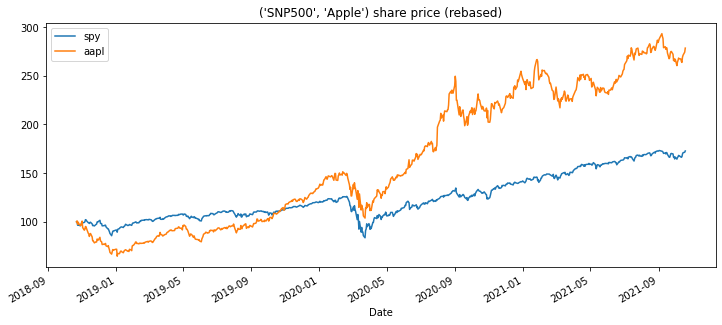

<IPython.core.display.Javascript object>

In [8]:
prices.rebase().plot(figsize=(12, 5))
plt.title(f"{tickers.value} share price (rebased)")
plt.show()

In [9]:
## Tabs

### stock statistics
stats_tab_output = widgets.Output()
with stats_tab_output:
    prices.calc_stats().display()


### correlations tab
correlation_tab_output = widgets.Output()
with correlation_tab_output:
    returns = prices.to_log_returns().dropna()
    ax = returns.hist(figsize=(12, 5))
    plt.show()

### yoy growth tab
monthly_returns_tab_output = widgets.Output()
yoy_growth_df = calc_yoy_growth(prices)

with monthly_returns_tab_output:
    for ticker in yoy_growth_df.columns:
        display(HTML(f"<hr><h3>{convert_ticker_to_company(ticker)}</h3>"))
        calmap_plot = plot_calmap(yoy_growth_df, ticker)
        plt.show()

### drawdown
drawdown_tab_output = widgets.Output()
with drawdown_tab_output:
    ax = prices.to_drawdown_series().plot()
    plt.title("Drawdown Plot")
    plt.show()


stock_summary_tab = widgets.VBox([stats_tab_output])
correlation_tab = widgets.VBox([correlation_tab_output])
monthly_returns_tab = widgets.VBox([monthly_returns_tab_output])
drawdown_tab = widgets.VBox([drawdown_tab_output])

output_box = widgets.Tab(
    children=[stock_summary_tab, correlation_tab, monthly_returns_tab, drawdown_tab],
    layout=widgets.Layout(height="398px"),
)

<IPython.core.display.Javascript object>

In [11]:
tab_names = ["Stock Statistics", "Correlations", "Year over year Growth", "Drawdown"]

for i, title in enumerate(tab_names):
    output_box.set_title(i, title)

display(output_box)

<IPython.core.display.Javascript object>

Created by [EngineeringforDataScience](https://engineeringfordatascience.com/) ⚒️ | [Source Code](https://github.com/julian-west/e4ds-snippets/tree/voila/jupyter/voila)